In [261]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [164]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn import utils

# Preprocess Data
In the <b>HW3_template</b> folder you will find `TSLA.csv`, `GOOGL.csv` and `DJI.csv` files. Use Pandas (You have used it in HW1) to retrieve the dataset. Use only <b>Open</b> price as your input. (You will train three models for three different stocks, don't mix these data together!)

In [7]:
tsla_data=pd.read_csv('TSLA.csv',sep=',',header=0)
googl_data=pd.read_csv('GOOGL.csv',sep=',',header=0)
dji_data=pd.read_csv('DJI.csv',sep=',',header=0)


In [40]:
tsla_open=tsla_data['Open']
googl_open=googl_data['Open']
dji_open=dji_data['Open']

In [41]:
tsla_open=(np.reshape([tsla_open],[-1,1]))
googl_open=np.reshape([googl_open],[-1,1])
dji_open=np.reshape([dji_open],[-1,1])

## Normalize your data
You could use `MinMaxScaler` in `sklearn.preprocessing` to normalize the data between 0 and 1.

In [43]:
#Tesla
tsla_scaler=MinMaxScaler()
tsla_scaler.fit(tsla_open)
tsla_open=tsla_scaler.transform(tsla_open)

#Google
googl_scaler=MinMaxScaler()
googl_scaler.fit(googl_open)
googl_open=googl_scaler.transform(googl_open)

#DOJ
dji_scaler=MinMaxScaler()
dji_scaler.fit(dji_open)
dji_open=dji_scaler.transform(dji_open)

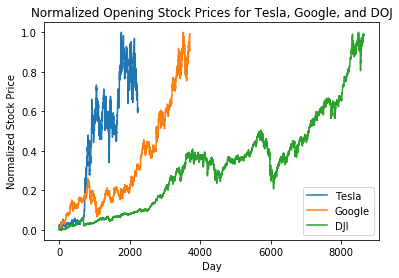

In [78]:
plt.plot(tsla_open)
plt.plot(googl_open)
plt.plot(dji_open)
plt.xlabel('Day')
plt.ylabel('Normalized Stock Price')
plt.title("Normalized Opening Stock Prices for Tesla, Google, and DOJ")
plt.legend(labels=('Tesla', 'Google','DJI'))

# Split training, validation and testing data
<p style="font-size:20px">Since you will impelement a many-to-one Recurrent Neural Network model, every input data will have shape [batch_size, num_seq, input_size] and output data will have shape [batch_size, input_size] 

In [86]:
from scipy.linalg import hankel
from sklearn.model_selection import train_test_split

In [107]:
def split_data(company,size):
    new_data=hankel(company[0:size],company[size:])
    x=new_data[0:-1]
    y=new_data[-1]
    x=np.transpose(x)
    return x,y
    
    

In [108]:
tsla_x,tsla_y=split_data(tsla_open,31)
google_x,google_y=split_data(googl_open,31)
dji_x,dji_y=split_data(dji_open,31)

In [109]:
np.shape(tsla_y)

(2196,)

In [110]:
def train_test_val(x,y):
    train_x,total_x,train_y,total_y=train_test_split(x,y,test_size=.2,shuffle=False,stratify=None)
    val_x,test_x,val_y,test_y=train_test_split(x,y,test_size=.5,shuffle=False,stratify=None)
    return train_x,train_y,val_x,val_y,test_x,test_y

In [111]:
t_train_x,t_train_y,t_val_x,t_val_y,t_test_x,t_test_y=train_test_val(tsla_x,tsla_y)
g_train_x,g_train_y,g_val_x,g_val_y,g_test_x,g_test_y=train_test_val(google_x,google_y)
d_train_x,d_train_y,d_val_x,d_val_y,d_test_x,d_test_y=train_test_val(dji_x,dji_y)

In [112]:
print(np.shape(t_train_x))
print(np.shape(t_train_y))

(1756, 30)
(1756,)


In [199]:
p=t_train_x
r=np.transpose(p)
k=[r]
print(np.shape(k))

(1, 30, 1756)


In [356]:

def mini_batch(features,labels,mini_batch_size):
    """
    Args:
        features: features for one batch
        labels: labels for one batch
        mini_batch_size: the mini-batch size you want to use.
    Hint: Use "yield" to generate mini-batch features and labels
    """
    #batch size is number of samples in each iteration 
    features,labels=utils.shuffle(features,labels)
    data_size=np.shape(labels)[0]
    its=data_size//mini_batch_size
    i=0
    j=mini_batch_size
    k=0
    while k != its:
        mb_features=features[i:j]
        mb_labels=labels[i:j]
        i+=mini_batch_size
        j+=mini_batch_size
        k+=1
        yield mb_features, mb_labels
        

# TesnorFlow Model

In [373]:
tf.reset_default_graph()

In [374]:
n_neurons=100
lr=.001
batch_size=128
num_seq=30
input_size=1
n_outputs=1
# X = tf.placeholder(tf.float32,[None,num_seq,input_size],name='X')
# Y = tf.placeholder(tf.float32,[None,n_outputs],name='Y')
X = tf.placeholder(tf.float32,[None,num_seq],name='X')
Y = tf.placeholder(tf.float32,[None],name='Y')

In [375]:
# lstm_cell=tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
def GRU(x):
    GRU_cell=tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.GRUCell(num_units=n_neurons,activation=tf.nn.relu),output_size=n_outputs)
    outputs,states=tf.nn.dynamic_rnn(GRU_cell,inputs=tf.expand_dims(x,-1),dtype=tf.float32)
    return outputs[:,-1,:]

In [376]:
#tf.shape(outputs[:,-1,:])

In [377]:
#define loss
outputs=GRU(X)
loss = tf.reduce_mean(tf.square(outputs-Y),name='loss')
#define optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

#compare the predicted labels with true labels
#correct_pred = tf.equal(tf.argmax(logits,1),tf.argmax(Y,1))

#compute the accuracy by taking average
#accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32),name='accuracy')


# Training

In [391]:
import time
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for i in range(5):
        #fetch batch
        #acc=[]
        st=time.time()
        #for j in range(1,6):
        for (a,b) in mini_batch(t_train_x,t_train_y,128):
#             batch_x, batch_y = np.expand_dims(a,-1), np.expand_dims(b,-1)
            batch_x, batch_y = a, b
                #run optimization
            sess.run(train_op, feed_dict={X:batch_x, Y:batch_y}) 
            lo=sess.run(loss,feed_dict={X:batch_x, Y:batch_y})
            #acc.append( sess.run(accuracy,feed_dict={X:batch_x, Y:batch_y}))
        mid=time.time()
        print("Epoch "+str(i)+", Time:{} ".format(mid-st)+", Loss= {:.3f}".format(lo))
        
        #batch_a,batch_b=np.expand_dims(t_val_x,-1),np.expand_dims(t_val_y,-1)
        batch_a,batch_b=t_val_x,t_val_y
        #batch_a=load_cifar_template1.features_reshape(batch_a)
        #val=sess.run(accuracy, feed_dict={X:batch_a, Y:batch_b})
        #print("Validation Accuracy:",val)
    
    print("Training finished!")
    testing=[]
#     for (a,b) in load_preprocessed_test_batch(128):
#         batch_x, batch_y = a, b
#     batch_a=np.expand_dims(np.expand_dims(t_test_x,-1)[0],0)
    #batch_a=np.expand_dims(np.expand_dims(t_test_x,-1)[0],0)
    batch_a=np.expand_dims(t_test_x[0],-1)
    
#     testing.append(batch_a)
    for i in range(len(t_test_x)):
        batch_new=sess.run(outputs, feed_dict={X:batch_a[i:i+num_seq].T})
        #print(np.squeeze(batch_new))
        #bb=np.squeeze(batch_new)
        batch_a=np.append(batch_a,batch_new,0)
        #batch_a=np.expand_dims(np.expand_dims(batch_a,-1)[0],0)
    #print("Testing Accuracy: {:.3f}".format(np.average(testing)))

Epoch 0, Time:1.1638562679290771 , Loss= 0.097
Epoch 1, Time:1.0681440830230713 , Loss= 0.075
Epoch 2, Time:1.2237277030944824 , Loss= 0.082
Epoch 3, Time:1.3154830932617188 , Loss= 0.078
Epoch 4, Time:1.2426767349243164 , Loss= 0.078
Training finished!


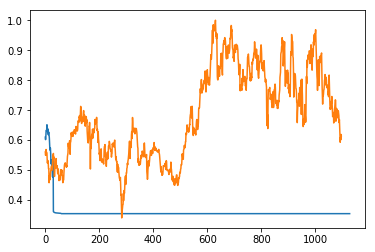

In [394]:
plt.plot(batch_a)
plt.plot(t_test_y[1:])

In [326]:
np.shape(np.expand_dims(t_test_x[0,:30],-1))

(30, 1)

In [320]:
np.shape(np.expand_dims(np.expand_dims(t_test_x,-1)[0],0))

(1, 30, 1)

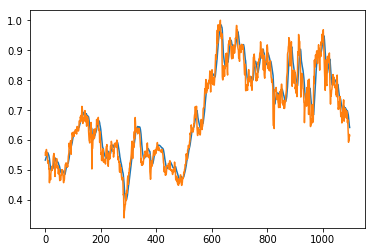

In [307]:
plt.plot(np.squeeze(testing)[0,:])
plt.plot(t_test_y)

In [281]:
ttt=np.squeeze(testing)

In [285]:
np.shape(t_test_y)

(1098,)

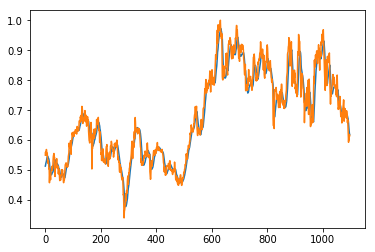

In [286]:
plt.plot(ttt)
plt.plot(t_test_y)

# Testing

In [262]:
# def predict(inputs):
#     if len(inputs[0,:,0]) < n_steps:
#         raise Exception("Insufficient inputs! X should be an array of shape (1, k, 1) where k >= n_steps")

#     with tf.Session(graph = graph) as sess:
#         saver.restore(sess, './{}'.format(save_name))

#         preds = []
#         steps_forward = len(inputs[0,:,0]) - n_steps + 1
#         for j in range(0, steps_forward):
#             X_in = inputs[:,j:j+n_steps,:]
#             y_pred = sess.run(outputs, feed_dict = {X: X_in})
#             preds.append(y_pred[0,-1,0]) # add the last one
#     return np.array(preds).reshape(-1, len(preds), 1)

In [272]:
with tf.Session() as sess:
    y_pred=sess.run(outputs,feed_dict={X:np.expand_dims(t_test_x,-1)})

FailedPreconditionError: Attempting to use uninitialized value rnn/output_projection_wrapper/gru_cell/gates/bias
	 [[node rnn/output_projection_wrapper/gru_cell/gates/bias/read (defined at C:\Users\ebish\Anaconda3\lib\site-packages\tensorflow\contrib\rnn\python\ops\core_rnn_cell.py:378)  = Identity[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](rnn/output_projection_wrapper/gru_cell/gates/bias)]]

Caused by op 'rnn/output_projection_wrapper/gru_cell/gates/bias/read', defined at:
  File "C:\Users\ebish\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\ebish\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\ebish\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\ebish\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "C:\Users\ebish\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\ebish\Anaconda3\lib\asyncio\base_events.py", line 422, in run_forever
    self._run_once()
  File "C:\Users\ebish\Anaconda3\lib\asyncio\base_events.py", line 1432, in _run_once
    handle._run()
  File "C:\Users\ebish\Anaconda3\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "C:\Users\ebish\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\ebish\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-255-563489ac2c44>", line 2, in <module>
    outputs=GRU(X)
  File "<ipython-input-253-888d39a24b7f>", line 4, in GRU
    outputs,states=tf.nn.dynamic_rnn(GRU_cell,x,dtype=tf.float32)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\tensorflow\python\ops\rnn.py", line 664, in dynamic_rnn
    dtype=dtype)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\tensorflow\python\ops\rnn.py", line 872, in _dynamic_rnn_loop
    swap_memory=swap_memory)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 3291, in while_loop
    return_same_structure)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 3004, in BuildLoop
    pred, body, original_loop_vars, loop_vars, shape_invariants)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 2939, in _BuildLoop
    body_result = body(*packed_vars_for_body)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 3260, in <lambda>
    body = lambda i, lv: (i + 1, orig_body(*lv))
  File "C:\Users\ebish\Anaconda3\lib\site-packages\tensorflow\python\ops\rnn.py", line 840, in _time_step
    (output, new_state) = call_cell()
  File "C:\Users\ebish\Anaconda3\lib\site-packages\tensorflow\python\ops\rnn.py", line 826, in <lambda>
    call_cell = lambda: cell(input_t, state)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\tensorflow\python\ops\rnn_cell_impl.py", line 233, in __call__
    return super(RNNCell, self).__call__(inputs, state)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\tensorflow\python\layers\base.py", line 374, in __call__
    outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 757, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\tensorflow\contrib\rnn\python\ops\core_rnn_cell.py", line 378, in call
    output, res_state = self._cell(inputs, state)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\tensorflow\python\ops\rnn_cell_impl.py", line 370, in __call__
    *args, **kwargs)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\tensorflow\python\layers\base.py", line 374, in __call__
    outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 746, in __call__
    self.build(input_shapes)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\tensorflow\python\keras\utils\tf_utils.py", line 149, in wrapper
    output_shape = fn(instance, input_shape)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\tensorflow\python\ops\rnn_cell_impl.py", line 543, in build
    else init_ops.constant_initializer(1.0, dtype=self.dtype)))
  File "C:\Users\ebish\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 495, in add_variable
    return self.add_weight(*args, **kwargs)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\tensorflow\python\layers\base.py", line 288, in add_weight
    getter=vs.get_variable)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 609, in add_weight
    aggregation=aggregation)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\tensorflow\python\training\checkpointable\base.py", line 639, in _add_variable_with_custom_getter
    **kwargs_for_getter)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 1487, in get_variable
    aggregation=aggregation)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 1237, in get_variable
    aggregation=aggregation)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 523, in get_variable
    return custom_getter(**custom_getter_kwargs)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\tensorflow\python\ops\rnn_cell_impl.py", line 236, in _rnn_get_variable
    variable = getter(*args, **kwargs)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 492, in _true_getter
    aggregation=aggregation)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 922, in _get_single_variable
    aggregation=aggregation)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 183, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 146, in _variable_v1_call
    aggregation=aggregation)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 125, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 2444, in default_variable_creator
    expected_shape=expected_shape, import_scope=import_scope)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 187, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 1329, in __init__
    constraint=constraint)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 1488, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "C:\Users\ebish\Anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py", line 81, in identity
    return gen_array_ops.identity(input, name=name)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 3454, in identity
    "Identity", input=input, name=name)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3274, in create_op
    op_def=op_def)
  File "C:\Users\ebish\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value rnn/output_projection_wrapper/gru_cell/gates/bias
	 [[node rnn/output_projection_wrapper/gru_cell/gates/bias/read (defined at C:\Users\ebish\Anaconda3\lib\site-packages\tensorflow\contrib\rnn\python\ops\core_rnn_cell.py:378)  = Identity[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](rnn/output_projection_wrapper/gru_cell/gates/bias)]]


In [266]:
np.shape(t_train_x)

(1756, 30)